<a href="https://colab.research.google.com/github/ImagingDataCommons/IDC-Examples/blob/master/notebooks/thoracic_oar_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to the Tutorial

The purpose of this tutorial is to educate users on: 

* How to select, access, and download cohorts from IDC;
* What are some of the tools that can be used to get the DICOM data ready for your favourite imaging analysis pipelines;
* How to run an end-to-end pipeline and visualise the final results exploiting the Google Cloud Computing (GCP) and IDC platform.

<br>

**To access the resources needed for this tutorial, you will need to be registered on the IDC platform and set up a GCP project.**

First, if you are not yet registered to IDC, [sign up at this link](https://portal.imaging.datacommons.cancer.gov/accounts/signup/) or simply make sure you can [sign in at the IDC portal via your Google account](https://portal.imaging.datacommons.cancer.gov/accounts/login/)

Second, creating a Google Cloud Computing project is easy and free. You should be able to do it at [this link](https://console.cloud.google.com/projectselector2/home/dashboard) in just a few clicks:
* Once the page opens up, click on the "Create Project" button on the right;
* Give the project a name (e.g., "my-first-project"), and select your organisation (or simply no organisation at all). 

You can read more about the creation and managing of GCP project at the [dedicated documentation page](https://cloud.google.com/appengine/docs/standard/nodejs/building-app/creating-project)




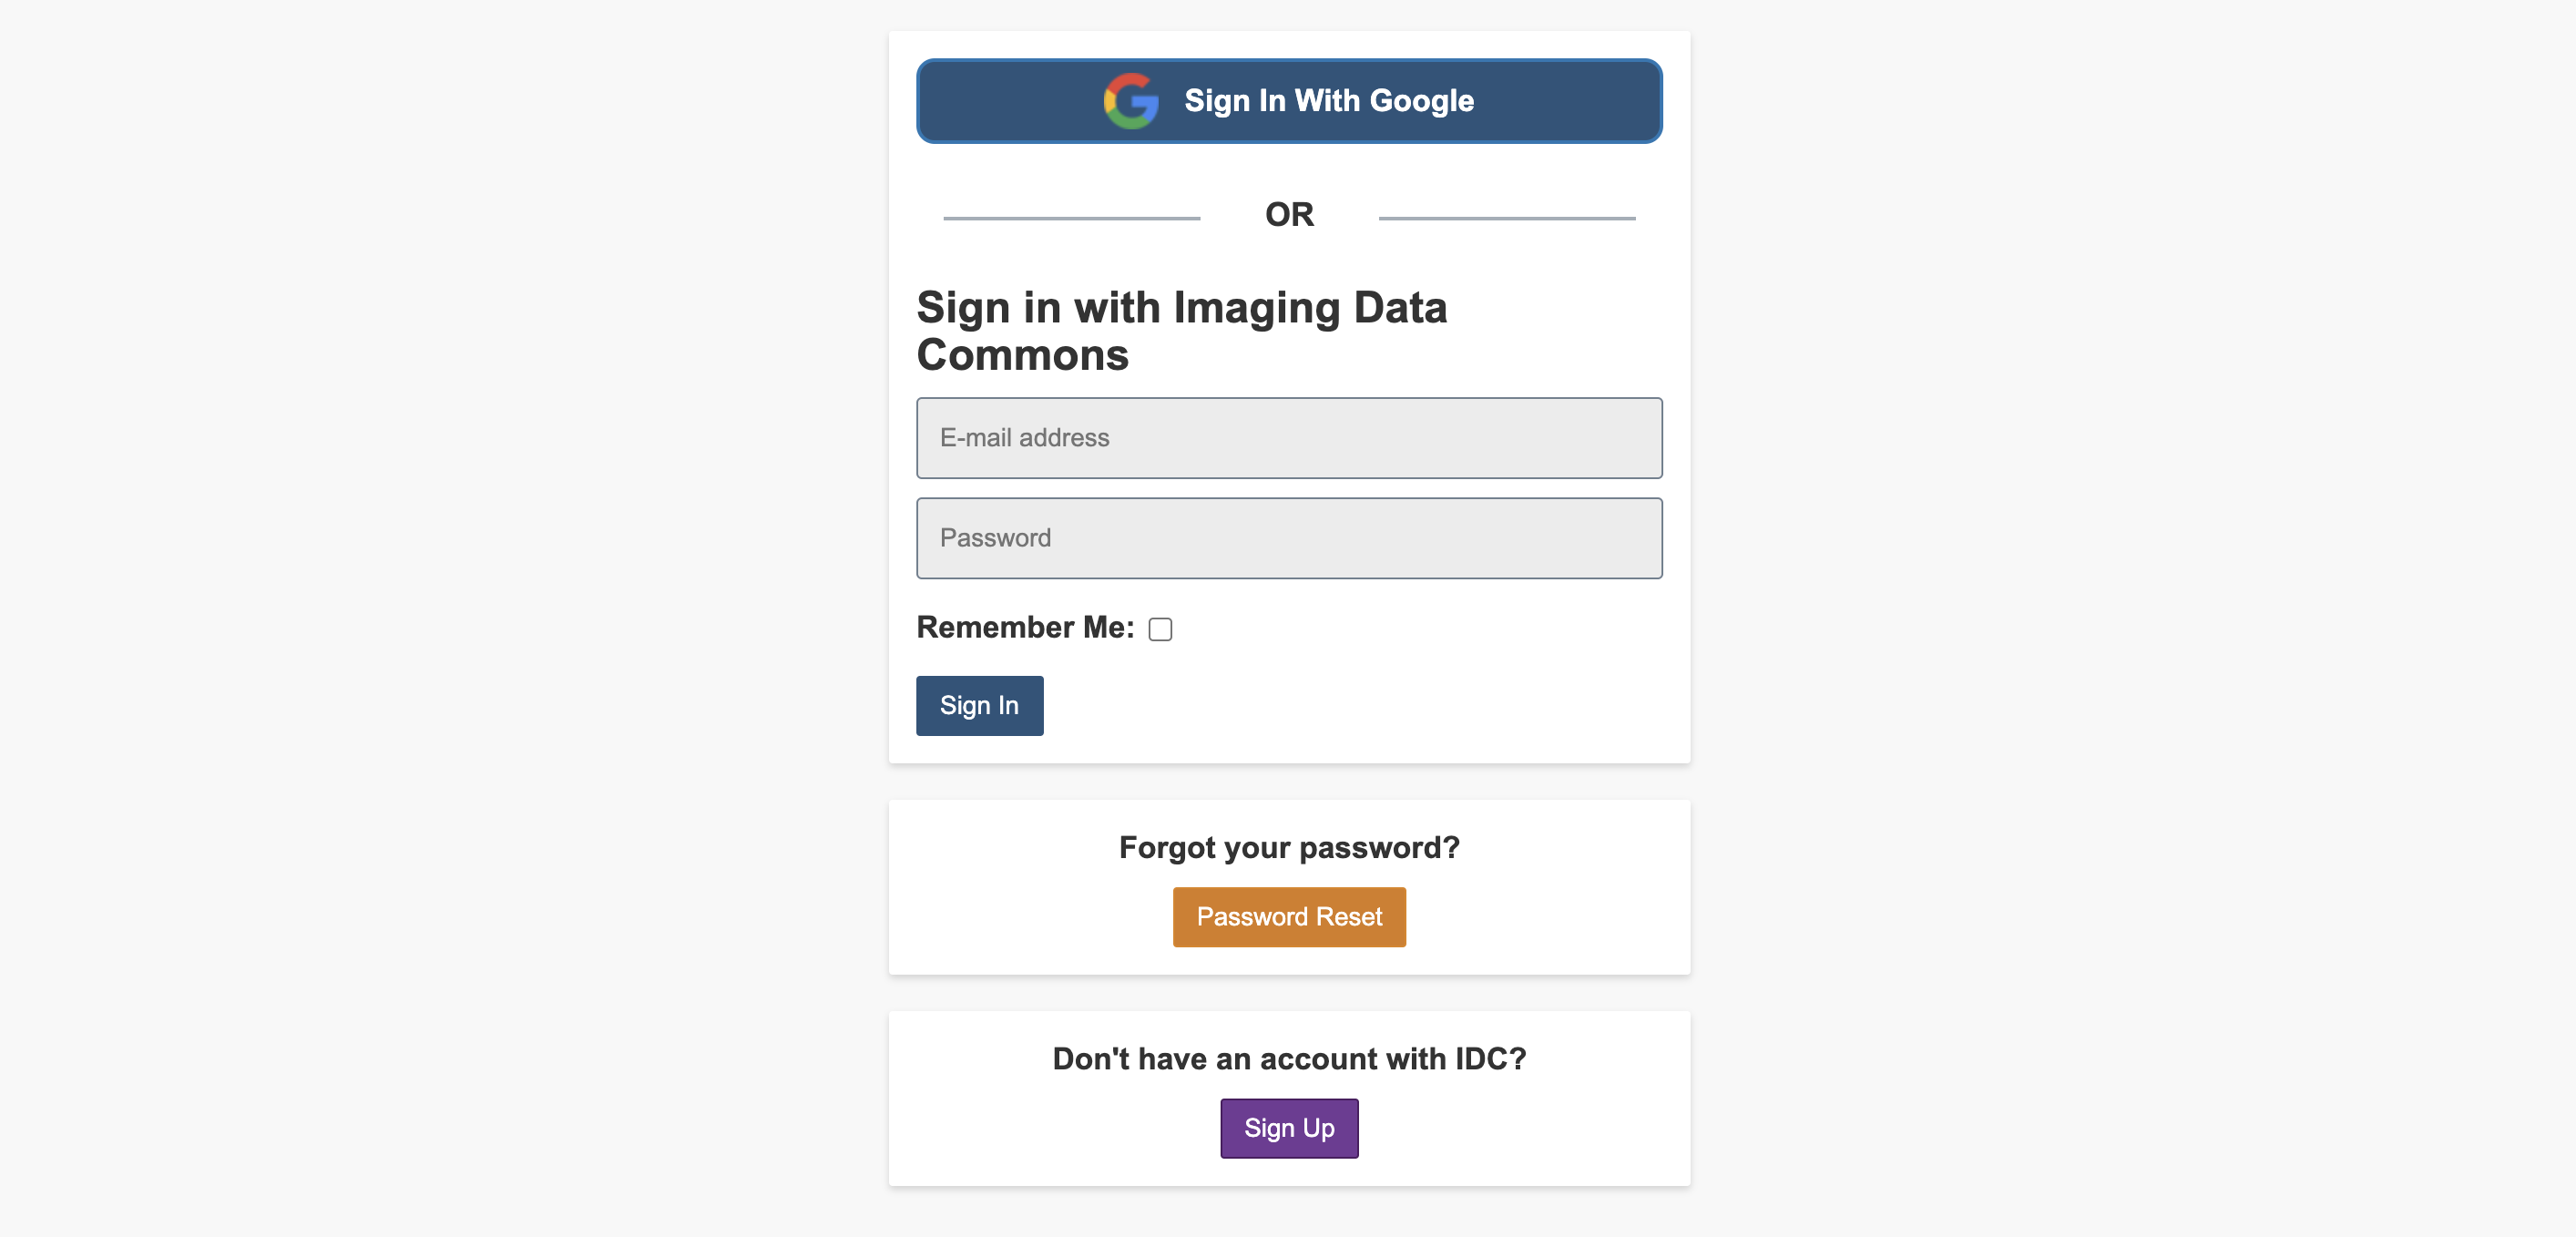

<br>

**To speed up the AI Image Processing pipelines, make sure the Colab Instance you are using is equipped with a GPU.**

You can check by clicking on "Runtime" in the menu bar, then selecting "Change Runtime Type" and making sure "GPU" is selected as Hardware acceleration. Colab GPUs include Nvidia K80s, T4s, P4s and P100s. As there is no way to choose what type of GPU you can connect to in Colab at any given time, processing times may vary.

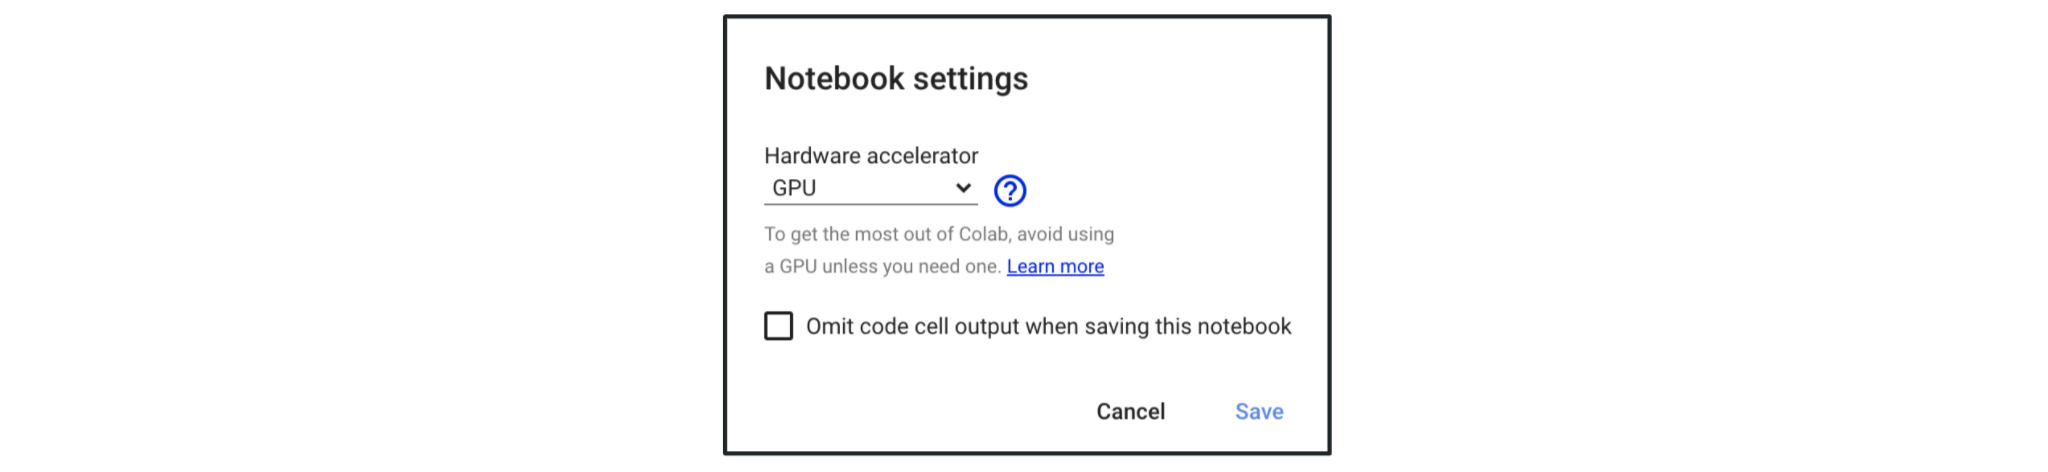

---

<br>

**In this notebook, we will test and end-to-end AI pipeline for thoracic organs at risk (OAR) segmentation from chest CT scans on patients from the Non-Small Cell Lung Cancer Radiomics (NSCLC-Radiomics) dataset.**

The AI pipeline exploits one of the pre-trained models shared as part of the [nn-Unet model collection](https://www.nature.com/articles/s41592-020-01008-z). This model was trained on the [_SegTHOR: segmentation of thoracic organs at risk in CT images_](https://competitions.codalab.org/competitions/21145) dataset to segment the heart, the aorta, the esophagus, and the trachea from chest CT scans.

<br>

**As mentioned above, the AI model deployed in this notebook has been trained on external and completely independent datasets from the IDC cohorts we are about to test them on.**

The idea behind this tutorial is therefore not to showcase a perfect AI-based processing pipeline, but rather investigate how IDC can help promoting transparency, reusability and reproducibility in AI - potentially accelerating the translation of these methods into clinical settings.


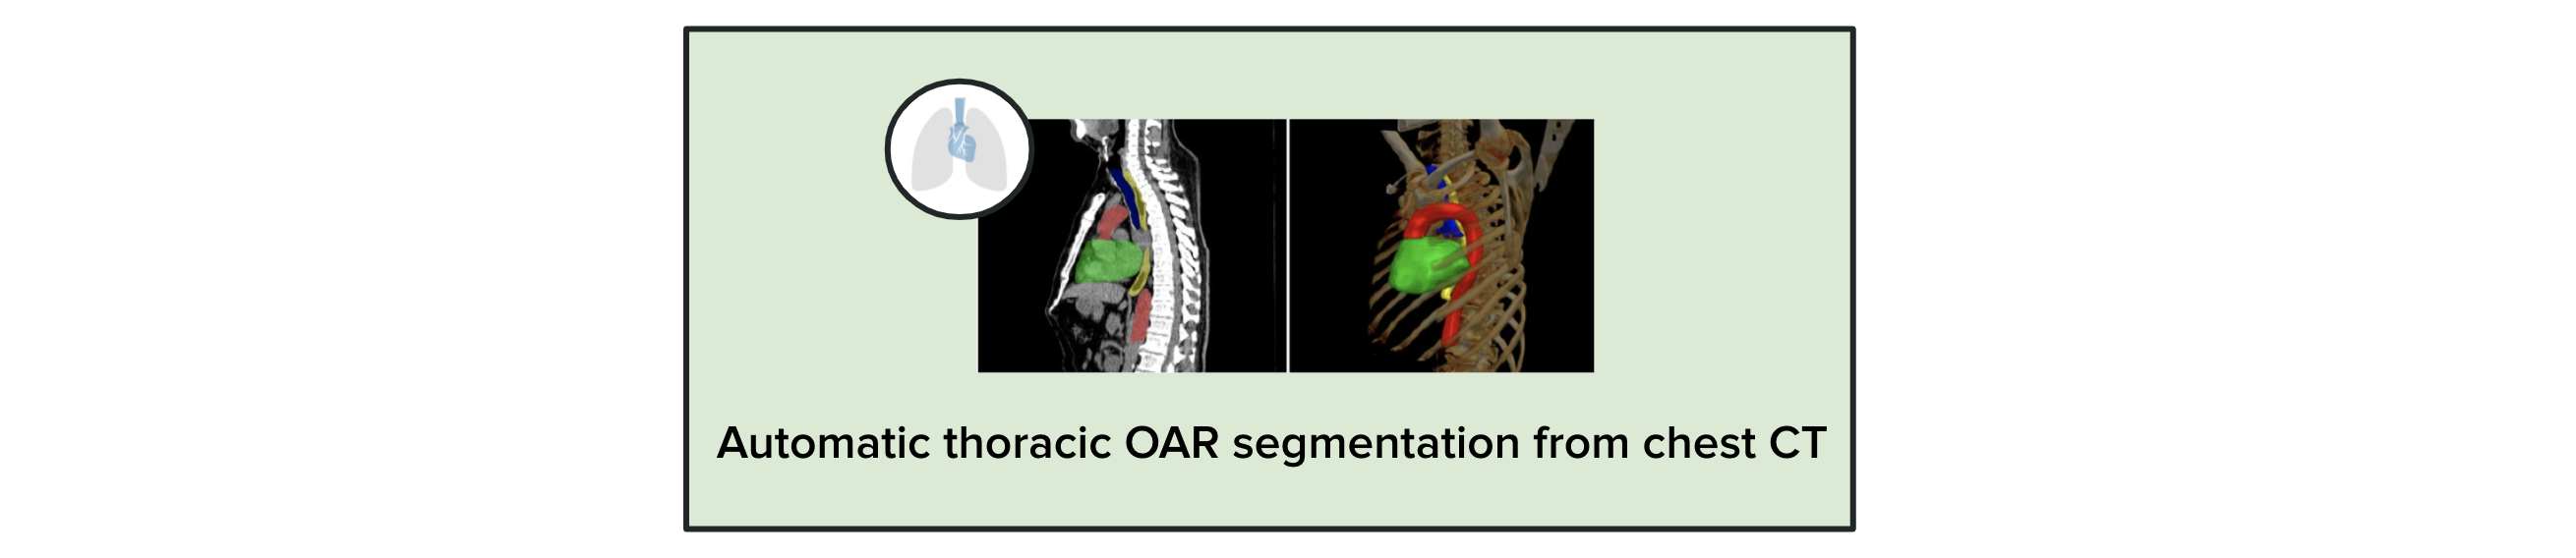

---

<br>

Since this demonstration runs in Google Colab, it highlights only a small part of what IDC can offer in terms of computational capability and imaging analysis: a more comprehensive experience of such tools can be explored, e.g., by experimenting with GCP Virtual Machines.

To learn more about how to access the GCP virtual machines for free (exploiting GCP and/or IDC [free cloud credits](https://learn.canceridc.dev/introduction/requesting-gcp-cloud-credits)) and about the IDC platform, please visit the [IDC user guide](https://learn.canceridc.dev/).

<br>

**Any questions, bugs to report, or features you would like to see implemented in IDC?**

You are welcome to get in touch with us at the [IDC discussion forum](https://discourse.canceridc.dev/)!


---

# Init & Imports

In order to access the IDC resources, the user must complete at first the Google authentication process.

To continue with the notebook, when prompted by the next code cell follow the generated link. After granting Google Cloud SDK access to the selected Google account, you will get a one-use login code. Copy the code, paste it in the blank space under the cell, and press enter to complete the authentication procedure.

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
curr_dir = !pwd
curr_droid = !hostname
curr_pilot = !whoami

print("Current directory :", curr_dir[-1])
print("Hostname          :", curr_droid[-1])
print("Username          :", curr_pilot[-1])

Current directory : /content
Hostname          : cfd63fbdda99
Username          : root


Before continuing with the notebook, we need to set-up the Google Colab environment by installing the Python and system dependencies the pre-processing and processing pipeline rely on.

## Python Dependencies

Install and import all the Python dependencies. 

The main python packages we need to install are:
* `nnunet` - which is the [codebase for the nn-UNet framework](https://github.com/MIC-DKFZ/nnUNet) we are going to be using for the segmentation step;
* `pydicom`, a Python [package](https://github.com/pydicom/pydicom) that lets the use read, modify, and write DICOM data in an easy "pythonic" way - that we are going to use to distinguish different DICOM objects from each other.

In [ ]:
%%capture
!pip install nnunet
!pip install pydicom

In [ ]:
# check wether the Colab Instance was correctly changed to a GPU instance
gpu_list = !nvidia-smi --list-gpus

has_gpu = False if "failed" in gpu_list[0] else True

In [ ]:
import os
import sys
import shutil

import time
import gdown

import json
import pprint
import numpy as np
import pandas as pd

import pydicom
import nibabel as nib
import SimpleITK as sitk

from medpy.metric.binary import dc as dice_coef
from medpy.metric.binary import hd as hausdorff_distance
from medpy.metric.binary import asd as avg_surf_distance

from medpy.filter.binary import largest_connected_component

# use the "tensorflow_version" magic to make sure TF 1.x is imported
%tensorflow_version 1.x
import tensorflow as tf
import keras

print("Python version               : ", sys.version.split('\n')[0])
print("Numpy version                : ", np.__version__)
print("TensorFlow version           : ", tf.__version__)
print("Keras (stand-alone) version  : ", keras.__version__)

print("\nThis Colab instance is equipped with a GPU.")

# ----------------------------------------

#everything that has to do with plotting goes here below
import matplotlib
matplotlib.use("agg")

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline
%config InlineBackend.figure_format = "png"

import ipywidgets as ipyw

## ----------------------------------------

# create new colormap appending the alpha channel to the selected one
# (so that we don't get a \"color overlay\" when plotting the segmask superimposed to the CT)
cmap = plt.cm.Reds
my_reds = cmap(np.arange(cmap.N))
my_reds[:,-1] = np.linspace(0, 1, cmap.N)
my_reds = ListedColormap(my_reds)

cmap = plt.cm.Greens
my_greens = cmap(np.arange(cmap.N))
my_greens[:,-1] = np.linspace(0, 1, cmap.N)
my_greens = ListedColormap(my_greens)

cmap = plt.cm.Blues
my_blues = cmap(np.arange(cmap.N))
my_blues[:,-1] = np.linspace(0, 1, cmap.N)
my_blues = ListedColormap(my_blues)

cmap = plt.cm.spring
my_spring = cmap(np.arange(cmap.N))
my_spring[:,-1] = np.linspace(0, 1, cmap.N)
my_spring = ListedColormap(my_spring)
## ----------------------------------------

import seaborn as sns

TensorFlow 1.x selected.
Python version               :  3.7.11 (default, Jul  3 2021, 18:01:19) 
Numpy version                :  1.19.5
TensorFlow version           :  1.15.2
Keras (stand-alone) version  :  2.3.1

This Colab instance is equipped with a GPU.


Using TensorFlow backend.


In [ ]:
# check which model of GPU the notebook is equipped with - a Tesla K80 or T4
# T4 is the best performing on the two - and can about half the GPU processing time

!nvidia-smi

Mon Sep  6 11:16:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## System Dependencies

Install all the system dependencies. 

The only package we will need for this tutorial is [Plastimatch](https://plastimatch.org/index.html). Plastimatch is considered to be the swiss army knife of medical images processing: we will use it to convert DICOM (CT, RTSTRUCT) series to NRRD files - but it can be used for a multitude of other tasks, such as registration, resampling, cropping, and computing statistics to name a few. Plastimatch is also available as a 3DSlicer plug-in and can be used directly from the Slicer GUI.

For the sake of clarity and simplicity, we will call Plastimatch from a very simple [Python wrapper](https://github.com/denbonte/pyplastimatch) written for the occasion (unfortunately, Plastimatch does not provide an official one) - more on this later.

In [ ]:
%%capture
!sudo apt update

!sudo apt install plastimatch

In [ ]:
!echo $(plastimatch --version)

plastimatch version 1.7.0


We are also going to install subversion, a tool that will allow us to clone GitHub repositories only partially (to save time and space).

In [ ]:
%%capture

!sudo apt install subversion

In [ ]:
!echo $(svn --version | head -n 2)

svn, version 1.9.7 (r1800392) compiled Mar 28 2018, 08:49:13 on x86_64-pc-linux-gnu


## Environment Setup

Set the Linux environment variables needed to run the nnU-Net pipeline. 

Three main variables are needed by default to run the nnU-Net segmentation pipelines:
* `nnUNet_raw_data_base` is the path to the folder where the segmentation pipeline expects to find the data to process;
* `nnUNet_preprocessed` is the path to the folder where the preprocessed data are saved;
* `RESULTS_FOLDER` is the path to the folder storing by default the model weights and, in our case, for simplicity, the segmentation masks produced by the pipeline.

We will use the additional variable `PATH_TO_MODEL_FILE` to point to the location where the pre-trained model weights for the chosen model will be stored (more on this later).

Please notice that these variables need to be set using `os.environ[]` in Google Colab - as `!export` is not sufficient to guarantee the variables are kept from one cell to the other. For more in-depth information regarding what the nnU-Net framework uses these folders for, please visit [the dedicated nnU-Net documentation page](https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/setting_up_paths.md)

In [ ]:
# set env variables for the bash process
os.environ['nnUNet_raw_data_base'] = "/content/tutorial/data/nnUNet_raw_data/"
os.environ['nnUNet_preprocessed'] = "/content/tutorial/data/processed/"

os.environ["RESULTS_FOLDER"] = "/content/tutorial/output/"
os.environ["PATH_TO_MODEL_FILE"] = "/content/tutorial/models/Task055_SegTHOR.zip"

# Model Download

Download all the files needed to load the pre-trained model.

## THoracic Organs at Risk Segmentation AI Model

While the nnU-Net framework should take care of the model download (from Zenodo), some of the zip files containing the pre-trained weights are particularly large, so the download can take a lot of time, get stuck, or produce errors (as [reported by other users](https://github.com/MIC-DKFZ/nnUNet/issues/358#issue-726410474) and in the [repository FAQ](https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/common_problems_and_solutions.md#downloading-pretrained-models-unzip-cannot-find-zipfile-directory-in-one-of-homeisenseennunetdownload_16031094034174126)) .

For this reason, and for the purpose of speeding up this tutorial, we decided to copy the relevant model weights in a shared Dropbox folder. In the following cells, we use Linux `wget` to pull such files from the folder - and exploit the nnU-Net framework command `nnUNet_install_pretrained_model_from_zip` to unpack and install the pre-trained model.

In [ ]:
# create the directory tree
!mkdir -p tutorial 
!mkdir -p tutorial/models tutorial/data tutorial/output
!mkdir -p tutorial/data/dicom tutorial/data/processed tutorial/data/nnUNet_raw_data

In [ ]:
# this will usually take between one and five minutes (but can sometimes take up to eight)
seg_model_url = "https://www.dropbox.com/s/m7es2ojn8h0ybhv/Task055_SegTHOR.zip?dl=0"
output_path = "tutorial/models/Task055_SegTHOR.zip"

!wget -O $output_path $seg_model_url

--2021-09-06 11:17:40--  https://www.dropbox.com/s/m7es2ojn8h0ybhv/Task055_SegTHOR.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/m7es2ojn8h0ybhv/Task055_SegTHOR.zip [following]
--2021-09-06 11:17:41--  https://www.dropbox.com/s/raw/m7es2ojn8h0ybhv/Task055_SegTHOR.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc08a38544c4800b60f5180d7f4c.dl.dropboxusercontent.com/cd/0/inline/BVq9ND9MNjKH57P-5pq871-y79bj11XsBnlu0Gvrp5HogkakXIa754FxYVFte57zcEviE1VEpkVhWixOssuizzprW0rjDHe032hqerPTuXP8A1WStl5AZqJNkfcFEeP32V5K4f4Ey0d8s21ivUABLEVu/file# [following]
--2021-09-06 11:17:41--  https://uc08a38544c4800b60f5180d7f4c.dl.dropboxusercontent.com/cd/0/inline/BVq9ND9MNjKH57P-5pq871-y79bj11XsBnlu0Gvrp5HogkakXIa754FxYVFte

Unpack and install model (under `PATH_TO_MODEL_FILE`).

In [ ]:
%%capture
!nnUNet_install_pretrained_model_from_zip $PATH_TO_MODEL_FILE

---

# Cohort Download

In this tutorial, we will test the end-to-end AI pipeline for lung nodule prognosis from CT scans on patients from the Non-Small Cell Lung Cancer Radiomics (NSCLC-Radiomics) dataset.

The NSCLC-Radiomics cohort contains images from stage I–IIIb NSCLC patients imaged with CT, with or without intravenous contrast, and treated with radiation therapy at MAASTRO Clinic, Maastricht, The Netherlands. Images were acquired between 2004 and 2010. For some of these patients pretreatment CT scans, manual delineation by a radiation oncologist of the 3D volume of the heart, the esophagus, and clinical outcome data are available. This dataset is referred to as "LUNG1" in [Aerts et Al. - Decoding tumour phenotype by noninvasive imaging using a quantitative radiomics approach](https://www.nature.com/articles/ncomms5006), (Nature Communications, 2014).

## Cohort(s) Selection on IDC

As the Imaging Data Commons GCS buckets are "[requester pays](https://cloud.google.com/storage/docs/requester-pays)" buckets, it is not possible to [mount such buckets directly in Colab](https://gist.github.com/korakot/f3600576720206363c734eca5f302e38).

Instead, what the users can do is to query the BigQuery table associated with the dataset(s), select the cohort(s) of interest, and then download the files exploiting `gsutil`. Such cohort selection operation can be done through the graphic user interface at the [IDC Portal](https://portal.imaging.datacommons.cancer.gov/): here follows a graphical summary of how to do so.

### Step 1 - Site Selection

On the [main page of the portal](https://portal.imaging.datacommons.cancer.gov/), click on a site icon to browse all the data related to the anatomical site of interest.

For the purpose of this notebook, we are interested in patients with chest CT, where the heart is fully captured - especially, patients with a delineation of the heart and other thoracic organs at risk available. For this reason, we are going to click on "Lung" as in the following image.

IDC_lung_click.png

### Step 2 - Data Browsing and Filtering

In the "Search Configuration" box on the left, click on "Derived" and then "Segmentation" to browse by the segmentation data available.

For the purpose of this notebook, we are interested in patients for which a manual delineation of (at least) the heart on chest CT is available.

exploration_click.png

Under "Segmentation Type", search and choose "Heart" to browse all the patients for which that information is available.

heart_click.png

### Step 3 - Saving a New Cohort and Exporting It

After logging in, (e.g., sign In with your Google Account) you will be able to save the selected cohort by clicking on "Save as New Cohort".

save_cohort_heart.png

To export the cohort data we need for the download, after choosing a name and a description, you will be able to click the same purple button which has now become "Export Cohort Manifest".

export_cohort_button.png


**N.B.**: in general, the data can be downloaded from IDC either using directly the manifest (the "not recommended" approach - generate GCS URIs from the manifest itself) or exploiting BigQuery queries. See this [cohort download notebook](https://github.com/ImagingDataCommons/IDC-Examples/blob/master/notebooks/Cohort_download.ipynb) to learn more about the process.

In this Notebook, we will exploit BigQuery tables to fetch the data from the IDC buckets (the "recommended" approach).

<br>

After clicking the "Export Cohort Manifest" button, when prompted, select "BigQuery" in the dialog box.

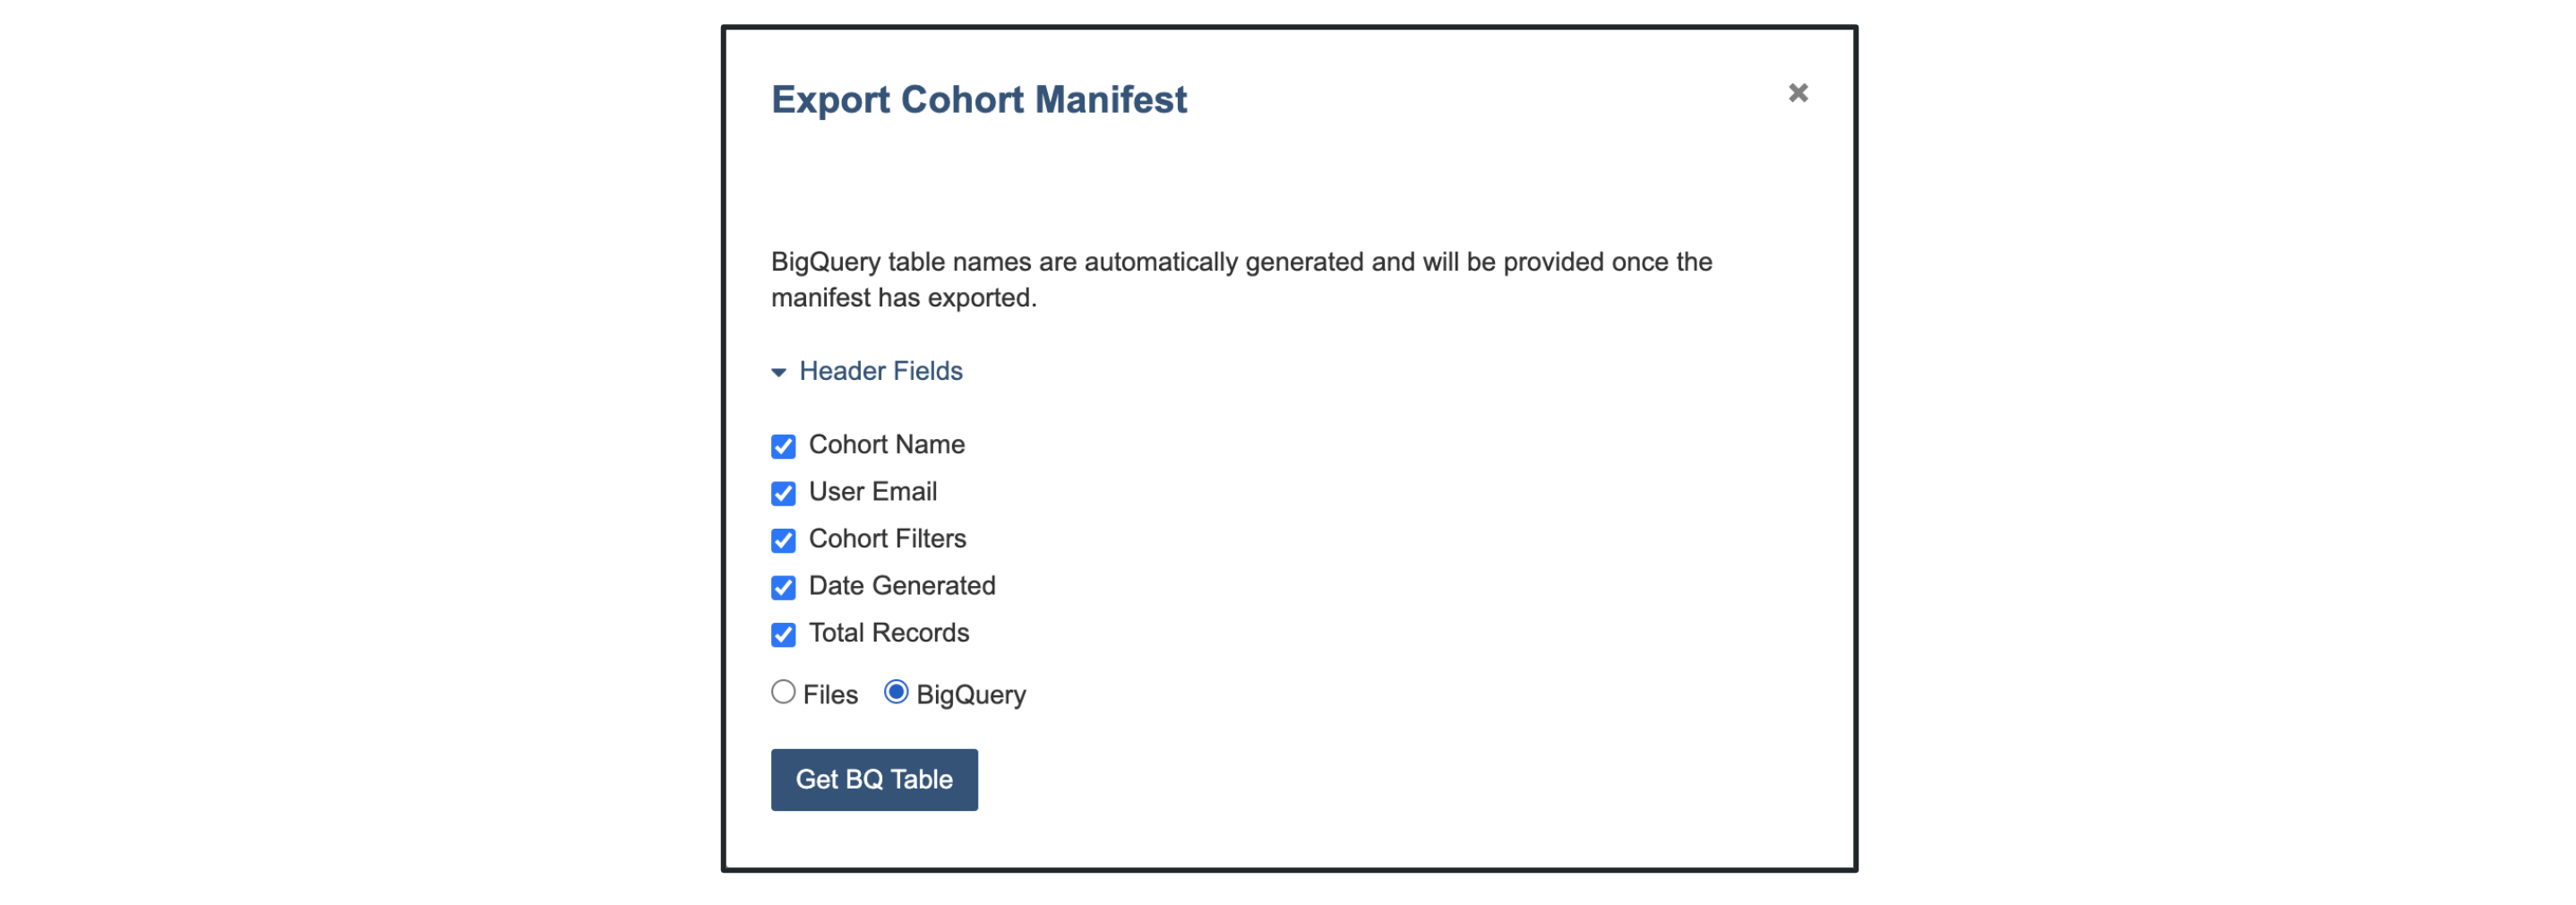

The portal will now generate the correspondend BigQuery query: once that is done, follow the link to the Google Cloud Computing platform and click on "Query" in the cohort manifest panel. You can copy the content of the query in the next code cell, remove the `LIMIT 1000` at the end, and procede with the next part of the notebook. 

query.png

## Downloading the Data from GCS

In the next cell, make sure to fill in the name of your GCP project and paste the query we obtained following the cells above.

At the end, it should look like the following:

```
%%bigquery --project=my-gcp-project cohort_df

SELECT * FROM `canceridc-user-data.user_manifests.manifest_cohort_222_20210811_071925`
```

In [ ]:
# magic   | name of the variable to save the table to |         project name      | 
%%bigquery cohort_df --project=$PROJECT_NAME_HERE 

SELECT * FROM `$BIGQUERY_TABLE_NAME_HERE`

After populating the Pandas DataFrame with the result of the bigquery query, we can inspect it to make sure it looks ok.

As you will see, each DICOM slice has its own entry (that's why one has to remove `LIMIT 1000` from the query to get the complete result) and a series of useful information:
* on the dataset it belongs to - especially useful in the case multiple datasets are exported as part of an IDC cohort - such as the `collection_id` and the `source_DOI`;
* on the patient, study, and series it belongs to, such as the `PatientID`, `StudyInstanceUID` and `SeriesInstanceUID`;
* on the GCS bucket location and organisation, such as `gcs_url`, `crdc_instance_uuid`, and `crdc_series_uuid`.



In [ ]:
cohort_df.head()

PatientID  ...                                            gcs_url
0  LUNG1-002  ...  gs://idc-open/eff917af-8a2a-42fe-9e12-22bceaac...
1  LUNG1-002  ...  gs://idc-open/f8cbf725-621d-4e18-8326-41789ea9...
2  LUNG1-002  ...  gs://idc-open/c73b3d12-78b1-4456-9a88-91ba2e0d...
3  LUNG1-002  ...  gs://idc-open/48b4ae0a-6936-44b4-a6bd-27c92471...
4  LUNG1-002  ...  gs://idc-open/3c36a30a-630b-4183-b87d-8a2389f3...

[5 rows x 10 columns]

We can now select a random patient from the dataframe, get all the `gcs_url` entries, and download the DICOM data associated with it (DICOM CT, DICOM RTSTRUCT and DICOM SEG, in this case).

<br>

**N.B.** - in order for the download from GCS to take place, the user needs to specify the GC project name again after `-u` option in the `gsutil` command. You can learn more about all the useful options `gsutil` provides the user with at the [dedicated documentation page](https://cloud.google.com/storage/docs/gsutil).

In [ ]:
gs_file_path = "tutorial/data/gcs_paths.txt"

# select patient randomly
unique_patid = np.unique(cohort_df["PatientID"].values)
n_patients = len(unique_patid)

pat_idx = np.random.randint(n_patients)
pat = unique_patid[pat_idx]

sliced_df = cohort_df[cohort_df["PatientID"] == pat]

sliced_df["gcs_url"].to_csv(gs_file_path, header = False, index = False)

In [ ]:
%%capture
# https://cloud.google.com/storage/docs/gsutil/commands/cp
!mkdir -p tutorial/data/tmp
!cat $gs_file_path | gsutil -m cp -Ir tutorial/data/tmp

As you will notice, for instance, by browsing the `tutorial/data/tmp` folder, the DICOM files will not be organised by default following patients, series, or studies.

To organise the data in a more common (and human-understandable) fashion, we will make use of [DICOMSort](https://github.com/pieper/dicomsort). DICOMSort is an open source tool for custom sorting and renaming of dicom files based on their specific DICOM tags. In our case, we will exploit DICOMSort to organise the DICOM data by `PatientID`, `StudyInstanceUID`, and `SeriesInstanceUID` - so that the final directory will look like the following:

```
tutorial/data/dicom/$PatientID
 └─── $StudyInstanceUID
       ├─── $SeriesInstanceUID_CT
       │     ├─── $SOPInstanceUID_slice0.dcm
       │     ├─── $SOPInstanceUID_slice1.dcm
       │     ├───  ...
       │
       ├─── $SeriesInstanceUID_RTSTRUCT
       │     └─── $SOPInstanceUID_RTSTRUCT.dcm
       │
       └─── $SeriesInstanceUID_RTSEG
             └─── $SOPInstanceUID_RTSEG.dcm

```

Furthermore, to prepare the data for processing (e.g., data conversion from DICOM) we will make use of [PyPlastimatch](https://github.com/denbonte/pyplastimatch/), a very basic python wrapper for Plastimatch, written for the purpose of this tutorial. The wrapper also contains a very basic yet interactive visualisation function we will be using in the last part of the notebook to check the segmentation results.

In [ ]:
# DICOMSORT - for re-organising DICOM files in folders
!git clone https://github.com/pieper/dicomsort.git tutorial/dicomsort

# PyPlastimatch - python wrapper for Plastimatch (and interactive notebook visualisation)
!svn checkout https://github.com/denbonte/pyplastimatch/trunk/pyplastimatch tutorial/pyplastimatch

Cloning into 'tutorial/dicomsort'...
remote: Enumerating objects: 126, done.
remote: Total 126 (delta 0), reused 0 (delta 0), pack-reused 126
Receiving objects: 100% (126/126), 37.03 KiB | 583.00 KiB/s, done.
Resolving deltas: 100% (63/63), done.
A    tutorial/pyplastimatch/pyplastimatch.py
A    tutorial/pyplastimatch/utils
A    tutorial/pyplastimatch/utils/data.py
A    tutorial/pyplastimatch/utils/viz.py
Checked out revision 7.


In [ ]:
# run the DICOMSort command
!python tutorial/dicomsort/dicomsort.py -u tutorial/data/tmp tutorial/data/dicom/%PatientID/%StudyInstanceUID/%SeriesInstanceUID/%SOPInstanceUID.dcm

# get rid of the temporary folder, storing the unsorted DICOM data 
!rm -r tutorial/data/tmp

100% 132/132 [00:01<00:00, 111.05it/s]
Files sorted


---

# Data Pre-processing

In order to run the AI segmentation pipeline, we need to convert the DICOM data in a format which python can easily handle

Using the simple Plastimatch wrapper, let's convert the DICOM CT series in both NRRD (very flexible, simple handling with SimpleITK) and NIfTI (as required by the nnU-Net pipeline) format. Furthermore, we are going to convert the DICOM RTSTRUCT Series into a NRRD volume as well - to allow for comparison between the manual and automatic segmentation, later in the notebook.


In [ ]:
from tutorial.pyplastimatch import pyplastimatch as pypla
from tutorial.pyplastimatch.utils import viz as viz_utils
from tutorial.pyplastimatch.utils import data as data_utils

Let's start by identifying the unique `SeriesInstanceUID` in our small dataset: 

In [ ]:
StudyInstanceUID = sliced_df["StudyInstanceUID"].values[0]
SeriesInstanceUID_list = sliced_df["SeriesInstanceUID"].values

SeriesInstanceUID_unique = list(np.unique(SeriesInstanceUID_list))

for SeriesInstanceUID in SeriesInstanceUID_unique:
  if len([x for x in SeriesInstanceUID_list if x == SeriesInstanceUID]) > 1:
    SeriesInstanceUID_ct = SeriesInstanceUID

SeriesInstanceUID_unique.remove(SeriesInstanceUID_ct)

Then, let's check the `Modality` tag of the DICOM Series to separate the CT Series from the RTSTRUCT and SEG ones.

In [ ]:
for SeriesInstanceUID in SeriesInstanceUID_unique:
  path_to_dcm_folder = os.path.join("tutorial/data/dicom", pat, StudyInstanceUID, SeriesInstanceUID)
  path_to_dcm_file = os.path.join(path_to_dcm_folder, os.listdir(path_to_dcm_folder)[0])

  if pydicom.dcmread(path_to_dcm_file).Modality == "SEG":
    SeriesInstanceUID_seg = SeriesInstanceUID
  
  if pydicom.dcmread(path_to_dcm_file).Modality == "RTSTRUCT":
    SeriesInstanceUID_rt = SeriesInstanceUID

## DICOM to NRRD/NIfTI Conversion

Finally, let's use the functions from the simple wrapper to convert the data into the formats mentioned above exploiting Plastimatch.

In [ ]:
# directories storing NRRD and NIfTI files
base_preproc_path = "tutorial/data/processed"

pat_dir_path_nrrd = os.path.join(base_preproc_path, "nrrd", pat)
pat_dir_path_nii = os.path.join(base_preproc_path, "nii", pat)
  
# patient subfolder where all the preprocessed NRRDs will be stored
if not os.path.exists(pat_dir_path_nrrd): os.makedirs(pat_dir_path_nrrd)
  
# patient subfolder where all the preprocessed NIfTIs will be stored
if not os.path.exists(pat_dir_path_nii): os.makedirs(pat_dir_path_nii)

# path to the directory where the DICOM CT file is stored
path_to_ct_dir = os.path.join("tutorial/data/dicom", pat,
                              StudyInstanceUID, SeriesInstanceUID_ct)

# path to the files where the NRRD and NIfTI CTs will be stored
ct_nrrd_path = os.path.join(pat_dir_path_nrrd, pat + "_ct.nrrd")
ct_nii_path = os.path.join(pat_dir_path_nii, pat + "_ct.nii.gz")


# path to the directory where the DICOM RTSTRUCT file is stored
path_to_rt_dir = os.path.join("tutorial/data/dicom", pat,
                              StudyInstanceUID, SeriesInstanceUID_rt)

# path to the files where the NRRD RTSTRUCTs will be stored
rt_folder = os.path.join(pat_dir_path_nrrd, "RTSTRUCT")
rt_list_path = os.path.join(pat_dir_path_nrrd, "RTSTRUCT_content")

verbose = True

# logfile for the plastimatch conversion
log_file_path_nrrd = os.path.join(pat_dir_path_nrrd, pat + '_pypla.log')
log_file_path_nii = os.path.join(pat_dir_path_nii, pat + '_pypla.log')
  
# DICOM CT to NRRD conversion (if the file doesn't exist yet)
if not os.path.exists(ct_nrrd_path):
  convert_args_ct = {"input" : path_to_ct_dir,
                     "output-img" : ct_nrrd_path}
  
  # clean old log file if it exist
  if os.path.exists(log_file_path_nrrd): os.remove(log_file_path_nrrd)
  
  pypla.convert(verbose = verbose, path_to_log_file = log_file_path_nrrd, **convert_args_ct)

# DICOM RTSTRUCT to NRRD conversion (if the file doesn't exist yet)
if not os.path.exists(rt_folder):
  convert_args_rt = {"input" : path_to_rt_dir, 
                     "referenced-ct" : path_to_ct_dir,
                     "output-prefix" : rt_folder,
                     "prefix-format" : 'nrrd',
                     "output-ss-list" : rt_list_path}
  
  # clean old log file if it exist
  if os.path.exists(log_file_path_nrrd): os.remove(log_file_path_nrrd)
  
  pypla.convert(verbose = verbose, path_to_log_file = log_file_path_nrrd, **convert_args_rt)

# DICOM CT to NIfTI conversion (if the file doesn't exist yet)
if not os.path.exists(ct_nii_path):
  convert_args_nii = {"input" : path_to_ct_dir, 
                      "output-img" : ct_nii_path}
  
  # clean old log file if it exist
  if os.path.exists(log_file_path_nii): os.remove(log_file_path_nii)
  
  pypla.convert(verbose = verbose, path_to_log_file = log_file_path_nii, **convert_args_nii)


Running 'plastimatch convert' with the specified arguments:
  --input tutorial/data/dicom/LUNG1-321/1.3.6.1.4.1.32722.99.99.190951747341156830518953385343476298086/1.3.6.1.4.1.32722.99.99.295304132827662774405775198447918257753
  --output-img tutorial/data/processed/nrrd/LUNG1-321/LUNG1-321_ct.nrrd
... Done.

Running 'plastimatch convert' with the specified arguments:
  --input tutorial/data/dicom/LUNG1-321/1.3.6.1.4.1.32722.99.99.190951747341156830518953385343476298086/1.3.6.1.4.1.32722.99.99.302073113579380192746962136872566047118
  --referenced-ct tutorial/data/dicom/LUNG1-321/1.3.6.1.4.1.32722.99.99.190951747341156830518953385343476298086/1.3.6.1.4.1.32722.99.99.295304132827662774405775198447918257753
  --output-prefix tutorial/data/processed/nrrd/LUNG1-321/RTSTRUCT
  --prefix-format nrrd
  --output-ss-list tutorial/data/processed/nrrd/LUNG1-321/RTSTRUCT_content
... Done.

Running 'plastimatch convert' with the specified arguments:
  --input tutorial/data/dicom/LUNG1-321/1.3.6.1.4

As a last step before running the lung nodules segmentation pipeline, we need to make sure the folder storing the data follows the structure required by the nnU-Net framework, described at the [dedicated documentation page](https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/dataset_conversion.md).

In [ ]:
# create a folder (random task name) for nnU-Net inference
proc_folder_path = os.path.join(os.environ["nnUNet_raw_data_base"],
                                "segthor", "imagesTs")

!mkdir -p $proc_folder_path

# populate the folder following the nnU-Net naming conventions
copy_path = os.path.join(proc_folder_path, pat + "_0000.nii.gz")

# copy NIfTI to the right dir for nnU-Net processing
if not os.path.exists(copy_path):
  shutil.copy(src = ct_nii_path, dst = copy_path)

## Inference Phase

In order to run the segmentation pipeline, we can follow the ["run inference" section of the nnU-Net documentation](https://github.com/MIC-DKFZ/nnUNet#how-to-run-inference-with-pretrained-models), specifying the path to the input and output folders defined in the sections above, and the pretrained model we want to use (i.e., the one we downloaded earlier).

For the purpose of this notebook, to make the processing faster, we are not going to use neither an ensemble of different U-Net configurations for inference nor test time augmentation (TTA). You are invited to explore these options later - and if you decide to do so, you can read [this example](https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/inference_example_Prostate.md) from the nnU-Net documentation to learn how this can be achieved.

To learn more about all the arguments that can be specified to the `nnUNet_predict` command, run `nnUNet_predict --help`.

In [ ]:
# run the inference phase
# accepted options for --model are: 2d, 3d_lowres, 3d_fullres or 3d_cascade_fullres
!nnUNet_predict --input_folder "tutorial/data/nnUNet_raw_data/segthor/imagesTs" \
                --output_folder $RESULTS_FOLDER \
                --task_name "Task055_SegTHOR" --model 2d --disable_tta 



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

using model stored in  /content/tutorial/output/nnUNet/2d/Task055_SegTHOR/nnUNetTrainerV2__nnUNetPlansv2.1
This model expects 1 input modalities for each image
Found 1 unique case ids, here are some examples: ['LUNG1-321']
If they don't look right, make sure to double check your filenames. They must end with _0000.nii.gz etc
number of cases: 1
number of cases that still need to be predicted: 1
emptying cuda cache
loading parameters for folds, None
folds is None so we will automatically look for output folders (not using 'all'!)
found the following folds:  ['/content/tutorial/output/nnUNet/2d/Task055_SegTHOR/nnUNetTrainerV2__nnUNet

## Data Post-processing

After the inference is finished, we can convert the segmentation masks back to NRRD for visualisation purposes and for easier handling.

In [ ]:
pred_nii_path = os.path.join(os.environ["RESULTS_FOLDER"], pat + ".nii.gz")

sitk_ct = sitk.ReadImage(ct_nrrd_path)

nrrd_spacing = sitk_ct.GetSpacing()
nrrd_dim = sitk_ct.GetSize()

nii_spacing = tuple(nib.load(pred_nii_path).header['pixdim'][1:4])
nii_dim = tuple(nib.load(pred_nii_path).get_fdata().shape)

assert (nrrd_spacing == nii_spacing) & (nrrd_dim == nii_dim)

## ----------------------------------------
# NIfTI TO NRRD CONVERSION

# path to the output NRRD file (inferred segmasks)
pred_nrrd_path = os.path.join(pat_dir_path_nrrd, pat + "_pred_segthor.nrrd")
log_file_path = os.path.join(pat_dir_path_nrrd, pat + "_pypla.log")

# Inferred NIfTI segmask to NRRD
convert_args_pred = {"input" : pred_nii_path, 
                     "output-img" : pred_nrrd_path}

pypla.convert(path_to_log_file = log_file_path, **convert_args_pred)


Running 'plastimatch convert' with the specified arguments:
  --input /content/tutorial/output/LUNG1-321.nii.gz
  --output-img tutorial/data/processed/nrrd/LUNG1-321/LUNG1-321_pred_segthor.nrrd
... Done.


# Visualising the Segmentation Masks

We can visualise the raw AI-inferred segmentation mask (heart, aorta, esophagus, amd treachea - in green, yellow, red, and blue, respectively) and compare the heart (and esophagus, if available for the randomly selected patient) segmentation to the manual delineation.

In [ ]:
# load NRRD volumes
ct_nrrd = sitk.GetArrayFromImage(sitk_ct)

# inferred segmask
pred_nrrd_segthor = sitk.GetArrayFromImage(sitk.ReadImage(pred_nrrd_path))

pred_nrrd_esophagus = np.copy(pred_nrrd_segthor)
pred_nrrd_heart = np.copy(pred_nrrd_segthor)
pred_nrrd_trachea = np.copy(pred_nrrd_segthor)
pred_nrrd_aorta = np.copy(pred_nrrd_segthor)
  
# zero every segmask other than the esophagus and make the mask binary (0/1)
pred_nrrd_esophagus[pred_nrrd_segthor != 1] = 0
pred_nrrd_esophagus[pred_nrrd_esophagus != 0] = 1
  
# zero every segmask other than the heart and make the mask binary (0/1)
pred_nrrd_heart[pred_nrrd_segthor != 2] = 0
pred_nrrd_heart[pred_nrrd_heart != 0] = 1
  
# zero every segmask other than the trachea and make the mask binary (0/1)
pred_nrrd_trachea[pred_nrrd_segthor != 3] = 0
pred_nrrd_trachea[pred_nrrd_trachea != 0] = 1
  
# zero every segmask other than the aorta and make the mask binary (0/1)
pred_nrrd_aorta[pred_nrrd_segthor != 4] = 0
pred_nrrd_aorta[pred_nrrd_aorta != 0] = 1


# manual segmask (from the RTSTRUCT)
rt_segmask_heart = os.path.join(pat_dir_path_nrrd, "RTSTRUCT", "Heart.nrrd")
rt_nrrd_heart = sitk.GetArrayFromImage(sitk.ReadImage(rt_segmask_heart))

try:
  rt_segmask_esophagus = os.path.join(pat_dir_path_nrrd, "RTSTRUCT", "Esophagus.nrrd")
  rt_nrrd_esophagus = sitk.GetArrayFromImage(sitk.ReadImage(rt_segmask_esophagus))
except:
  # for the sake of simplicity, fill the volume with zeros
  # (so that we can keep the code that comes after the same)
  rt_nrrd_esophagus = np.zeros(rt_nrrd_heart.shape)

In [ ]:
_ = viz_utils.AxialSliceSegmaskComparison(ct_volume = ct_nrrd,
                                          segmask_ai_dict = {"Heart" : pred_nrrd_heart,
                                                             "Aorta" : pred_nrrd_aorta,
                                                             "Trachea" : pred_nrrd_trachea,
                                                             "Esophagus" : pred_nrrd_esophagus},
                                          segmask_manual_dict = {"Heart" : rt_nrrd_heart,
                                                                 "Esophagus" : rt_nrrd_esophagus},
                                          segmask_cmap_dict = {"Heart" : my_greens,
                                                               "Aorta" : my_spring,
                                                               "Esophagus" : my_reds,
                                                               "Trachea" : my_blues},
                                          dpi = 100)

interactive(children=(Output(),), _dom_classes=('widget-interact',))

# Quantitative Performance

Let's start by defining a function to compute the center of mass (CoM) of the segmentation masks. Before computing the common segmentation metrics, the CoM can give us a rough idea of how different the 3D delineations are and if there are any major labelling errors (which we could correct, e.g., with a largest connected component analysis).

We will base our function on the [implementation](https://github.com/AIM-Harvard/pyradiomics/blob/master/radiomics/generalinfo.py) found in the open source [PyRadiomics library](https://github.com/AIM-Harvard/pyradiomics).

In [ ]:
def getCenterOfMassIndexValue(input_mask):
    
    """
    Returns z, y and x coordinates of the center of mass of the ROI in terms of
    the image coordinate space (continuous index).

    Calculation is based on the original (non-resampled) mask.
    Because this represents the continuous index, the order of x, y and z is reversed,
    i.e. the first element is the z index, the second the y index and the last element is the x index.

    @params:
      input_mask - required : numpy (binary) volume storing the segmentation mask.

    """

    if input_mask is not None:
      mask_coordinates = np.array(np.where(input_mask == 1))
      center_index = np.mean(mask_coordinates, axis = 1)
      return tuple(center_index)
    else:
      return None

In [ ]:
com_manual_heart = np.array(getCenterOfMassIndexValue(rt_nrrd_heart))
com_manual_heart_int = np.ceil(com_manual_heart).astype(dtype = np.uint16)

com_raw_heart = np.array(getCenterOfMassIndexValue(pred_nrrd_heart))
com_raw_heart_int = np.ceil(com_raw_heart).astype(dtype = np.uint16)

print("Heart Center of Mass (raw AI segmentation) \t:", com_raw_heart_int)
print("Heart Center of Mass (manual segmentation) \t:", com_manual_heart_int)

Heart Center of Mass (raw AI segmentation) 	: [ 47 182 277]
Heart Center of Mass (manual segmentation) 	: [ 45 182 278]


In [ ]:
com_manual_heart = np.array(getCenterOfMassIndexValue(rt_nrrd_heart))
com_manual_heart_int = np.ceil(com_manual_heart).astype(dtype = np.uint16)

com_raw_heart = np.array(getCenterOfMassIndexValue(pred_nrrd_heart))
com_raw_heart_int = np.ceil(com_raw_heart).astype(dtype = np.uint16)

print("Heart Center of Mass (raw AI segmentation) \t:", com_raw_heart_int)
print("Heart Center of Mass (manual segmentation) \t:", com_manual_heart_int)

## ----------------------------------------

# run this if and only if a manual esophagus segmentation mask is available
if np.sum(rt_nrrd_esophagus):

  com_manual_esophagus = np.array(getCenterOfMassIndexValue(rt_nrrd_esophagus))
  com_manual_esophagus_int = np.ceil(com_manual_esophagus).astype(dtype = np.uint16)

  com_raw_esophagus = np.array(getCenterOfMassIndexValue(pred_nrrd_esophagus))
  com_raw_esophagus_int = np.ceil(com_raw_esophagus).astype(dtype = np.uint16)

  print("\nEsophagus Center of Mass (raw AI segmentation) \t:", com_raw_esophagus_int)
  print("Esophagus Center of Mass (manual segmentation) \t:", com_manual_esophagus_int)

Heart Center of Mass (raw AI segmentation) 	: [ 47 182 277]
Heart Center of Mass (manual segmentation) 	: [ 45 182 278]

Esophagus Center of Mass (raw AI segmentation) 	: [ 65 236 267]
Esophagus Center of Mass (manual segmentation) 	: [ 75 239 263]


Another common way to evaluate the quality of the segmentation is computing the Dice Coefficient between the AI segmentation and the manual one. To do so, we will use [MedPy's implementation of the Dice coefficient](https://loli.github.io/medpy/generated/medpy.metric.binary.dc.html#medpy-metric-binary-dc) (for binary masks).

We can use other MedPy's functions to compute the Hausdorff distance and the average surface distance as well*.

_*in most cases, the Hausdorff Distance will be quite high for both the heart segmentation and, if available with the randomly selected patient, the esophagus one. This is not a clear indication the model performance is poor: rather, it could also be the segmentation guidelines of the two datasets (the one the nnU-Net model was trained on and the external and independent validation dataset pulled from IDC) differ significantly._

In [ ]:
voxel_spacing = list(sitk_ct.GetSpacing())

dc_heart = dice_coef(pred_nrrd_heart, rt_nrrd_heart)
hd_heart = hausdorff_distance(pred_nrrd_heart, rt_nrrd_heart, voxelspacing = voxel_spacing)
asd_heart = avg_surf_distance(pred_nrrd_heart, rt_nrrd_heart, voxelspacing = voxel_spacing)

print("Heart Dice Coefficient (raw segmentation) :", dc_heart)
print("Heart Hausdorff Distance (raw segmentation) [mm]:", hd_heart)
print("Heart Average Surface Distance (raw segmentation) [mm]:", asd_heart)


# run this if and only if a manual esophagus segmentation mask is available
if np.sum(rt_nrrd_esophagus):
  dc_esophagus = dice_coef(pred_nrrd_esophagus, rt_nrrd_esophagus)
  hd_esophagus = hausdorff_distance(pred_nrrd_esophagus, rt_nrrd_esophagus, voxelspacing = voxel_spacing)
  asd_esophagus = avg_surf_distance(pred_nrrd_esophagus, rt_nrrd_esophagus, voxelspacing = voxel_spacing)

  print("\nEsophagus Dice Coefficient (raw segmentation) :", dc_esophagus)
  print("Esophagus Hausdorff Distance (raw segmentation) [mm]:", hd_esophagus)
  print("Esophagus Average Surface Distance (raw segmentation) [mm]:", asd_esophagus) 

Heart Dice Coefficient (raw segmentation) : 0.8313388632066708
Heart Hausdorff Distance (raw segmentation) [mm]: 13.423193692495463
Heart Average Surface Distance (raw segmentation) [mm]: 2.533094536515703

Esophagus Dice Coefficient (raw segmentation) : 0.7125488008923592
Esophagus Hausdorff Distance (raw segmentation) [mm]: 33.92622629421678
Esophagus Average Surface Distance (raw segmentation) [mm]: 2.6490144220748184
